In [1]:
from transformers import DistilBertTokenizer,DistilBertConfig, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import roc_curve, auc
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score
from transformers import TrainerCallback

#torch.cuda.set_per_process_memory_fraction(device=0, fraction=1.0)

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-06-02 13:18:23.983438: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train = pd.read_csv("data/cooked_dataset_train.csv", encoding='utf-8', index_col='Unnamed: 0')  
valid = pd.read_csv("data/cooked_dataset_valid.csv", encoding='utf-8', index_col='Unnamed: 0')
test =  pd.read_csv("data/cooked_dataset_test.csv", encoding='utf-8', index_col='Unnamed: 0')


#train, remaining = train_test_split(df, test_size=0.3, random_state=42)
#valid, test = train_test_split(remaining, test_size=0.5, random_state=42)

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
tokenizer = DistilBertTokenizer.from_pretrained("DeepPavlov/distilrubert-tiny-cased-conversational")
model = DistilBertForSequenceClassification.from_pretrained("DeepPavlov/distilrubert-tiny-cased-conversational").to(device)

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/distilrubert-tiny-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Загрузка модели предобученной

config = DistilBertConfig.from_pretrained("DeepPavlov/distilrubert-tiny-cased-conversational")
model_state = torch.load("/kaggle/working/model_distilrubert_latest.pth")

model_trained = DistilBertForSequenceClassification(config)

model_trained.load_state_dict(model_state)

In [7]:
train_texts = train['clean_text'].tolist()
train_labels = train['generated'].tolist()

valid_texts = valid['clean_text'].tolist()
valid_labels = valid['generated'].tolist()

test_texts = test['clean_text'].tolist()  
test_labels = test['generated'].tolist() 


# Токенизация текста
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

# Преобразование в тензоры PyTorch
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels)
)
valid_dataset = torch.utils.data.TensorDataset(
    torch.tensor(valid_encodings['input_ids']),
    torch.tensor(valid_encodings['attention_mask']),
    torch.tensor(valid_labels)
)
test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask']),
    torch.tensor(test_labels)
)


In [10]:
class DataCollatorForSequenceClassification:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, examples):
        input_ids = [example[0].tolist() for example in examples]
        attention_masks = [example[1].tolist() for example in examples]
        labels = [example[2].item() for example in examples]

        batch = {
            "input_ids": torch.tensor(input_ids),
            "attention_mask": torch.tensor(attention_masks),
            "labels": torch.tensor(labels)
        }
        return batch

In [9]:
training_args = TrainingArguments(
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    evaluation_strategy="epoch",
    logging_dir="./logs",
    output_dir="./results",
    logging_steps=200,  
    save_total_limit=1,  
)

data_collator = DataCollatorForSequenceClassification(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=data_collator,
)
trainer.train()

  4%|▍         | 200/5170 [00:37<14:43,  5.63it/s]

{'loss': 0.2461, 'grad_norm': 4.030544281005859, 'learning_rate': 4.8065764023210835e-05, 'epoch': 0.19}


  8%|▊         | 400/5170 [01:12<14:11,  5.60it/s]

{'loss': 0.1008, 'grad_norm': 0.48942869901657104, 'learning_rate': 4.613152804642167e-05, 'epoch': 0.39}


 12%|█▏        | 600/5170 [01:57<13:33,  5.62it/s]  

{'loss': 0.0701, 'grad_norm': 5.6540207862854, 'learning_rate': 4.4197292069632494e-05, 'epoch': 0.58}


 15%|█▌        | 800/5170 [02:32<12:56,  5.63it/s]

{'loss': 0.0522, 'grad_norm': 0.15376675128936768, 'learning_rate': 4.226305609284333e-05, 'epoch': 0.77}


 19%|█▉        | 1000/5170 [03:08<12:21,  5.63it/s]

{'loss': 0.0435, 'grad_norm': 4.447539806365967, 'learning_rate': 4.032882011605416e-05, 'epoch': 0.97}


 99%|█████████▊| 219/222 [00:12<00:00, 17.33it/s]
                                                   A
100%|██████████| 222/222 [00:12<00:00, 17.49it/s]
                                                 

{'eval_loss': 0.022382304072380066, 'eval_runtime': 12.8011, 'eval_samples_per_second': 553.782, 'eval_steps_per_second': 17.342, 'epoch': 1.0}


 23%|██▎       | 1200/5170 [04:06<11:46,  5.62it/s]  

{'loss': 0.0179, 'grad_norm': 0.009402363561093807, 'learning_rate': 3.839458413926499e-05, 'epoch': 1.16}


 27%|██▋       | 1400/5170 [04:41<11:12,  5.61it/s]

{'loss': 0.0256, 'grad_norm': 5.589451789855957, 'learning_rate': 3.646034816247582e-05, 'epoch': 1.35}


 31%|███       | 1600/5170 [05:26<10:34,  5.63it/s]  

{'loss': 0.0131, 'grad_norm': 0.011608628556132317, 'learning_rate': 3.452611218568665e-05, 'epoch': 1.55}


 35%|███▍      | 1800/5170 [06:02<09:58,  5.63it/s]

{'loss': 0.0149, 'grad_norm': 0.013097943738102913, 'learning_rate': 3.2591876208897484e-05, 'epoch': 1.74}


 39%|███▊      | 2000/5170 [06:37<09:23,  5.62it/s]

{'loss': 0.0131, 'grad_norm': 0.05473192036151886, 'learning_rate': 3.065764023210832e-05, 'epoch': 1.93}


 99%|█████████▊| 219/222 [00:12<00:00, 17.35it/s]
                                                   A
100%|██████████| 222/222 [00:12<00:00, 17.50it/s]
                                                 

{'eval_loss': 0.0251699797809124, 'eval_runtime': 12.7745, 'eval_samples_per_second': 554.934, 'eval_steps_per_second': 17.378, 'epoch': 2.0}


 43%|████▎     | 2200/5170 [07:35<08:49,  5.61it/s]  

{'loss': 0.0064, 'grad_norm': 0.005556472111493349, 'learning_rate': 2.8723404255319154e-05, 'epoch': 2.13}


 46%|████▋     | 2400/5170 [08:10<08:11,  5.64it/s]

{'loss': 0.0015, 'grad_norm': 0.0008817290654405951, 'learning_rate': 2.678916827852998e-05, 'epoch': 2.32}


 50%|█████     | 2600/5170 [08:56<07:37,  5.62it/s]  

{'loss': 0.0015, 'grad_norm': 0.002258149441331625, 'learning_rate': 2.4854932301740812e-05, 'epoch': 2.51}


 54%|█████▍    | 2800/5170 [09:31<07:01,  5.62it/s]

{'loss': 0.0046, 'grad_norm': 0.2672608494758606, 'learning_rate': 2.2920696324951645e-05, 'epoch': 2.71}


 58%|█████▊    | 3000/5170 [10:07<06:25,  5.64it/s]

{'loss': 0.0044, 'grad_norm': 0.0004749166837427765, 'learning_rate': 2.0986460348162475e-05, 'epoch': 2.9}


 99%|█████████▊| 219/222 [00:12<00:00, 17.36it/s]
                                                   A
100%|██████████| 222/222 [00:12<00:00, 17.48it/s]
                                                 

{'eval_loss': 0.02889896184206009, 'eval_runtime': 12.8246, 'eval_samples_per_second': 552.765, 'eval_steps_per_second': 17.31, 'epoch': 3.0}


 62%|██████▏   | 3200/5170 [11:05<05:49,  5.63it/s]  

{'loss': 0.0018, 'grad_norm': 0.00046932059922255576, 'learning_rate': 1.9052224371373308e-05, 'epoch': 3.09}


 66%|██████▌   | 3400/5170 [11:40<05:14,  5.62it/s]

{'loss': 0.0023, 'grad_norm': 0.00047034246381372213, 'learning_rate': 1.711798839458414e-05, 'epoch': 3.29}


 70%|██████▉   | 3600/5170 [12:25<04:38,  5.63it/s]  

{'loss': 0.0003, 'grad_norm': 0.00026984777650795877, 'learning_rate': 1.5183752417794972e-05, 'epoch': 3.48}


 74%|███████▎  | 3800/5170 [13:01<04:03,  5.64it/s]

{'loss': 0.0021, 'grad_norm': 0.0004204152792226523, 'learning_rate': 1.3249516441005803e-05, 'epoch': 3.68}


 77%|███████▋  | 4000/5170 [13:36<03:27,  5.63it/s]

{'loss': 0.0012, 'grad_norm': 0.0002791195875033736, 'learning_rate': 1.1315280464216636e-05, 'epoch': 3.87}


 99%|█████████▊| 219/222 [00:12<00:00, 17.33it/s]
                                                   A
100%|██████████| 222/222 [00:12<00:00, 17.43it/s]
                                                 

{'eval_loss': 0.029324667528271675, 'eval_runtime': 12.7767, 'eval_samples_per_second': 554.837, 'eval_steps_per_second': 17.375, 'epoch': 4.0}


 81%|████████  | 4200/5170 [14:35<02:52,  5.61it/s]  

{'loss': 0.0006, 'grad_norm': 0.0010383707704022527, 'learning_rate': 9.381044487427467e-06, 'epoch': 4.06}


 85%|████████▌ | 4400/5170 [15:11<02:17,  5.62it/s]

{'loss': 0.0009, 'grad_norm': 0.00041639807750470936, 'learning_rate': 7.446808510638298e-06, 'epoch': 4.26}


 89%|████████▉ | 4600/5170 [15:55<01:41,  5.62it/s]

{'loss': 0.0003, 'grad_norm': 0.0001988302101381123, 'learning_rate': 5.51257253384913e-06, 'epoch': 4.45}


 93%|█████████▎| 4800/5170 [16:30<01:05,  5.64it/s]

{'loss': 0.0, 'grad_norm': 0.0009842220460996032, 'learning_rate': 3.5783365570599615e-06, 'epoch': 4.64}


 97%|█████████▋| 5000/5170 [17:06<00:30,  5.61it/s]

{'loss': 0.0005, 'grad_norm': 17.994951248168945, 'learning_rate': 1.644100580270793e-06, 'epoch': 4.84}


 99%|█████████▊| 219/222 [00:12<00:00, 17.37it/s]
                                                   A
100%|██████████| 5170/5170 [17:57<00:00,  4.80it/s]A

{'eval_loss': 0.030200891196727753, 'eval_runtime': 12.8213, 'eval_samples_per_second': 552.909, 'eval_steps_per_second': 17.315, 'epoch': 5.0}
{'train_runtime': 1077.8921, 'train_samples_per_second': 153.457, 'train_steps_per_second': 4.796, 'train_loss': 0.024214577278828454, 'epoch': 5.0}


TrainOutput(global_step=5170, training_loss=0.024214577278828454, metrics={'train_runtime': 1077.8921, 'train_samples_per_second': 153.457, 'train_steps_per_second': 4.796, 'total_flos': 7504920908083200.0, 'train_loss': 0.024214577278828454, 'epoch': 5.0})

In [13]:
eval_results = trainer.evaluate(eval_dataset=test_dataset)
print(eval_results)
torch.save(model.state_dict(), "model_distilrubert_pre_trained.pth")

100%|██████████| 222/222 [00:12<00:00, 17.35it/s]


{'eval_loss': 0.0236799456179142, 'eval_runtime': 12.8127, 'eval_samples_per_second': 553.358, 'eval_steps_per_second': 17.327, 'epoch': 5.0}


In [11]:
from torch.utils.data import DataLoader

batch_size = 32
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


model.eval()


true_labels = []
predicted_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch[0].to(device) 
        attention_mask = batch[1].to(device)  
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)
        predicted_labels.extend(predictions.detach().cpu().numpy())
        true_labels.extend(batch[2])

print(len(true_labels), ' ', len(predicted_labels))


assert len(true_labels) == len(predicted_labels), "Количество истинных меток не совпадает с количеством предсказанных меток"

if len(true_labels) == len(predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    auc_score = roc_auc_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("ROC AUC:", auc_score)
    print("F1 score:", f1)
else:
    print("Количество истинных меток не совпадает с количеством предсказанных меток.")


7090   7090
Accuracy: 0.9950634696755994
Recall: 0.9936111111111111
ROC AUC: 0.9950863578478192
F1 score: 0.9951314508276534


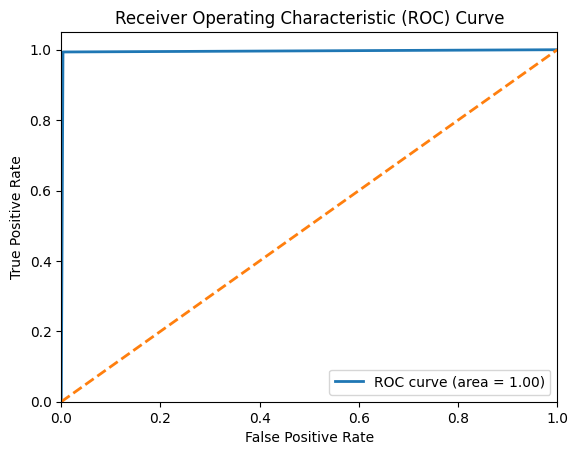

In [12]:
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
roc_auc_score_ = auc(fpr, tpr)  

plt.figure()
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score_)  
plt.plot([0, 1], [0, 1],  lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=1)

true_labels = test_labels

accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
auc_score = roc_auc_score(true_labels, predictions.predictions[:, 1]) 
f1 = f1_score(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("ROC AUC:", auc_score)
print("F1 score:", f1)